# Benchmark y Análisis Completo de PACO en VIP-master

Este notebook realiza:
1. **Análisis de Errores**: Detecta problemas en la implementación de PACO
2. **Carga de Datasets**: Descarga datasets desde GitHub (subchallenge1)
3. **Benchmark Completo**: Mide tiempos de ejecución con diferentes datasets
4. **Profiling**: Analiza el rendimiento del algoritmo
5. **Visualizaciones**: Genera gráficos y reportes

## Configuración para Colab

1. **Seleccionar Runtime**: Runtime > Change runtime type > Hardware accelerator: GPU (opcional)
2. **Ejecutar todas las celdas**: Runtime > Run all

## Autor
César Cerda - Universidad del Bío-Bío


## 1. Instalación de Dependencias


In [ ]:
# Instalar dependencias necesarias
!pip install -q astropy scipy matplotlib ipywidgets
!pip install -q memory-profiler line-profiler

print("[OK] Dependencias instaladas")


[OK] Dependencias instaladas


## 2. Clonar Repositorios


In [ ]:
# Clonar repositorios necesarios
import os
from pathlib import Path

# URLs de los repositorios
VIP_REPO_URL = "https://github.com/vortex-exoplanet/VIP.git"
TESIS_REPO_URL = "https://github.com/Waofin/tesis.git"

# Directorios de destino
REPOS_DIR = Path("/content/repos")
VIP_DIR = REPOS_DIR / "VIP"
TESIS_DIR = REPOS_DIR / "tesis"

# Crear directorio de repositorios
REPOS_DIR.mkdir(exist_ok=True)

print("="*70)
print("CLONANDO REPOSITORIOS")
print("="*70)

# Clonar VIP si no existe
if not VIP_DIR.exists():
    print(f"Clonando VIP desde {VIP_REPO_URL}...")
    !cd {REPOS_DIR} && git clone {VIP_REPO_URL}
    print("✓ VIP clonado correctamente")
else:
    print("✓ VIP ya existe")

# Clonar repositorio de tesis (para datasets)
# IMPORTANTE: Los archivos están en Git LFS, necesitamos clonar con LFS habilitado
if not TESIS_DIR.exists():
    print(f"\nClonando repositorio de tesis desde {TESIS_REPO_URL}...")
    print("  (Los archivos están en Git LFS, instalando git-lfs si es necesario...)")

    # Instalar git-lfs si no está disponible
    print("  Instalando Git LFS...")
    !apt-get update -qq 2>&1 | head -3
    !apt-get install -y git-lfs 2>&1 | tail -3
    !git lfs install 2>&1

    # Clonar con LFS
    print("  Clonando repositorio...")
    !cd {REPOS_DIR} && git clone {TESIS_REPO_URL} 2>&1 | tail -5

    # Intentar descargar archivos LFS
    if TESIS_DIR.exists():
        print("  Descargando archivos LFS (esto puede tardar varios minutos)...")
        print("  Por favor espera, los archivos son grandes...")
        !cd {TESIS_DIR} && git lfs pull 2>&1 | tail -10
        print("  ✓ Descarga de LFS completada")

    print("✓ Repositorio de tesis clonado correctamente")
else:
    print("✓ Repositorio de tesis ya existe")
    # Verificar si los archivos LFS están descargados
    print("  Verificando archivos LFS...")
    test_file = TESIS_DIR / "subchallenge1" / "sphere_irdis_1_cube.fits"
    if test_file.exists():
        # Verificar si es puntero
        try:
            with open(test_file, 'rb') as f:
                first_bytes = f.read(100)
                if b'git-lfs' in first_bytes or b'version https://git-lfs' in first_bytes:
                    print("  ⚠ Los archivos son punteros LFS, descargando contenido real...")
                    !cd {TESIS_DIR} && git lfs pull 2>&1 | tail -10
                else:
                    print("  ✓ Los archivos LFS ya están descargados")
        except:
            print("  ✓ Archivos encontrados")
    else:
        print("  ⚠ Archivos no encontrados, intentando descargar LFS...")
        !cd {TESIS_DIR} && git lfs pull 2>&1 | tail -10

print(f"\n✓ Repositorios disponibles en: {REPOS_DIR}")


CLONANDO REPOSITORIOS
✓ VIP ya existe
✓ Repositorio de tesis ya existe
  Verificando archivos LFS...
  ⚠ Archivos no encontrados, intentando descargar LFS...

✓ Repositorios disponibles en: /content/repos


## 3. Instalar VIP


In [ ]:
# Instalar VIP desde el repositorio clonado
print("="*70)
print("INSTALANDO VIP")
print("="*70)

if VIP_DIR.exists():
    print(f"Instalando VIP desde {VIP_DIR}...")
    !cd {VIP_DIR} && pip install -q -e .
    print("[OK] VIP instalado correctamente")
else:
    print("[WARNING] VIP no encontrado, instalando desde PyPI...")
    !pip install -q vip-hci
    print("[OK] VIP instalado desde PyPI")

# Verificar instalación
import sys
vip_src = VIP_DIR / "src"
if vip_src.exists():
    if str(vip_src) not in sys.path:
        sys.path.insert(0, str(vip_src))
    print(f"[OK] VIP agregado al path: {vip_src}")

try:
    import vip_hci as vip
    vip_version = vip.__version__ if hasattr(vip, '__version__') else 'desconocida'
    print(f"[OK] VIP importado correctamente (version: {vip_version})")
except ImportError as e:
    print(f"[ERROR] Error importando VIP: {e}")


INSTALANDO VIP
Instalando VIP desde /content/repos/VIP...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for vip_hci (pyproject.toml) ... done
[OK] VIP instalado correctamente
[OK] VIP agregado al path: /content/repos/VIP/src
[OK] VIP importado correctamente (version: 2.0.0)


## 4. Importar Librerías y Cargar Funciones de Benchmark


In [ ]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import traceback
from pathlib import Path
import warnings
import urllib.request
from astropy.io import fits
import pandas as pd
warnings.filterwarnings('ignore')

# Profiling
try:
    import cProfile
    import pstats
    from io import StringIO
    PROFILING_AVAILABLE = True
except ImportError:
    PROFILING_AVAILABLE = False

# Detectar GPU
try:
    import torch
    GPU_AVAILABLE = torch.cuda.is_available()
    if GPU_AVAILABLE:
        gpu_name = torch.cuda.get_device_name(0)
        print(f"[OK] GPU disponible: {gpu_name}")
    else:
        print("[WARNING] GPU no disponible, usando CPU")
except ImportError:
    GPU_AVAILABLE = False
    print("[WARNING] PyTorch no disponible")

print("="*70)
print("CONFIGURACIÓN COMPLETA")
print("="*70)

# Cargar funciones del script de benchmark
# Si el script está disponible, lo importamos; si no, definimos las funciones aquí
try:
    # Intentar cargar desde el script si está en el mismo directorio
    sys.path.insert(0, str(Path.cwd()))
    from benchmark_paco_vip import (
        load_challenge_dataset,
        benchmark_paco,
        PACOErrorDetector
    )
    print("[OK] Funciones de benchmark cargadas desde script")
except ImportError:
    print("[WARNING] Script no encontrado, las funciones se definiran en las siguientes celdas")


[OK] GPU disponible: Tesla T4
CONFIGURACIÓN COMPLETA
[WARNING] Script no encontrado, las funciones se definiran en las siguientes celdas


## 5. Análisis de Errores y Cargar/Ejecutar Benchmark

**[WARNING] IMPORTANTE**:
- Si obtienes errores 404 o "Descargando desde URL", **reinicia el kernel** (Kernel > Restart) y ejecuta todas las celdas desde el inicio.
- Las funciones deben usar el repositorio clonado localmente, NO descargar desde URLs.
- Asegúrate de haber ejecutado la celda 2 (Clonar Repositorios) antes de esta.


In [ ]:
# Si las funciones no se importaron, las definimos aquí
# IMPORTANTE: Los archivos están en Git LFS, por lo que debemos usar el repositorio clonado
# NO descargamos desde URLs raw porque los archivos están en Git LFS

# Limpiar cualquier definición anterior de la función
if 'load_challenge_dataset_simple' in globals():
    del load_challenge_dataset_simple
if 'benchmark_paco_simple' in globals():
    del benchmark_paco_simple

REPO_URL = "https://github.com/Waofin/tesis"

# Verificar que TESIS_DIR esté definido
if 'TESIS_DIR' not in globals():
    raise NameError("TESIS_DIR no está definido. Ejecuta la celda 2 (Clonar Repositorios) primero.")

# Función simplificada para cargar datasets
# Usa el repositorio clonado en lugar de descargar desde GitHub (los archivos están en Git LFS)
def load_challenge_dataset_simple(repo_url, instrument, dataset_id, local_dir=None, branch='main'):
    """
    Carga un dataset completo desde el repositorio clonado.

    NOTA: Los archivos están en Git LFS, por lo que deben estar en el repositorio clonado.
    Si el repositorio no está clonado con Git LFS, los archivos serán punteros.
    """
    # Usar el repositorio clonado en lugar de descargar
    # El repositorio debería estar en /content/repos/tesis
    repo_local_path = TESIS_DIR / "subchallenge1"

    if not repo_local_path.exists():
        raise ValueError(f"Repositorio no encontrado en {repo_local_path}. "
                        f"Asegúrate de haber clonado el repositorio en la celda 2.")

    # El formato correcto es: {instrument}_cube_{dataset_id}.fits
    # NO: {instrument}_{dataset_id}_cube.fits
    files = {
        'cube': f"{instrument}_cube_{dataset_id}.fits",
        'pa': f"{instrument}_pa_{dataset_id}.fits",
        'psf': f"{instrument}_psf_{dataset_id}.fits",
        'pxscale': f"{instrument}_pxscale_{dataset_id}.fits"
    }

    print(f"Cargando {instrument}_{dataset_id} desde repositorio clonado...")
    print(f"  Ruta: {repo_local_path}")

    # Verificar que el repositorio existe
    if not TESIS_DIR.exists():
        raise ValueError(f"ERROR: El repositorio no está clonado en {TESIS_DIR}. "
                        f"Por favor ejecuta la celda 2 primero para clonar el repositorio.")

    if not repo_local_path.exists():
        raise ValueError(f"ERROR: La carpeta subchallenge1 no existe en {repo_local_path}. "
                        f"Verifica que el repositorio se clonó correctamente.")

    # Listar archivos disponibles para debug
    available_files = list(repo_local_path.glob("*.fits"))
    print(f"  Archivos .fits encontrados en la carpeta: {len(available_files)}")
    if len(available_files) > 0:
        print(f"  Primeros archivos: {[f.name for f in available_files[:5]]}")

    # Verificar y descargar archivos LFS si es necesario
    print("  Verificando archivos LFS...")
    import subprocess

    # Intentar instalar git-lfs si no está disponible
    try:
        result = subprocess.run(['git', 'lfs', 'version'],
                              capture_output=True, text=True, timeout=5)
        if result.returncode != 0:
            print("  Instalando Git LFS...")
            !apt-get update -qq && apt-get install -y git-lfs 2>&1 | head -5
            !git lfs install 2>&1
    except Exception as e:
        print(f"  [WARNING] Git LFS check fallo: {e}")

    # Intentar descargar archivos LFS
    print("  Descargando archivos LFS (esto puede tardar)...")
    try:
        result = subprocess.run(['git', 'lfs', 'pull'],
                              cwd=str(TESIS_DIR),
                              capture_output=True,
                              text=True,
                              timeout=120)
        if result.returncode == 0:
            print("  [OK] Archivos LFS descargados correctamente")
        else:
            print(f"  [WARNING] Git LFS pull fallo: {result.stderr[:200]}")
    except subprocess.TimeoutExpired:
        print("  [WARNING] Git LFS pull tardo demasiado, continuando...")
    except Exception as e:
        print(f"  [WARNING] Error ejecutando git lfs pull: {e}")

    # Cargar archivos desde el repositorio clonado
    cube_path = repo_local_path / files['cube']

    # Verificar si el archivo existe o es un puntero LFS
    if not cube_path.exists():
        # Buscar archivos similares
        similar = list(repo_local_path.glob(f"*{instrument}*{dataset_id}*.fits"))
        if similar:
            print(f"  [WARNING] Archivo exacto no encontrado, pero hay archivos similares: {[f.name for f in similar]}")
        raise FileNotFoundError(f"Archivo no encontrado: {cube_path}\n"
                               f"Archivos disponibles: {[f.name for f in available_files if instrument in f.name]}")

    # Verificar si es un puntero LFS
    is_lfs_pointer = False
    try:
        with open(cube_path, 'rb') as f:
            first_bytes = f.read(100)
            first_line = first_bytes.decode('utf-8', errors='ignore')
            if 'git-lfs' in first_line or 'version https://git-lfs' in first_line:
                is_lfs_pointer = True
                print(f"  [WARNING] Archivo {files['cube']} es un puntero LFS")
    except:
        pass  # Si no es texto, probablemente es un archivo binario válido

    if is_lfs_pointer:
        print("  Intentando descargar archivos LFS nuevamente...")
        try:
            subprocess.run(['git', 'lfs', 'pull', '--include', f'subchallenge1/{files["cube"]}'],
                         cwd=str(TESIS_DIR),
                         check=False,
                         timeout=60)
        except:
            pass

    print(f"  Cargando cube: {files['cube']}")
    cube = fits.getdata(cube_path)
    print(f"    [OK] Cube shape: {cube.shape}")

    pa_path = repo_local_path / files['pa']
    if not pa_path.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {pa_path}")
    print(f"  Cargando angulos: {files['pa']}")
    angles = fits.getdata(pa_path).flatten()
    print(f"    [OK] Angulos shape: {angles.shape}")

    psf_path = repo_local_path / files['psf']
    if not psf_path.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {psf_path}")
    print(f"  Cargando PSF: {files['psf']}")
    psf = fits.getdata(psf_path)
    print(f"    [OK] PSF shape: {psf.shape}")

    pxscale_path = repo_local_path / files['pxscale']
    if pxscale_path.exists():
        print(f"  Cargando pixel scale: {files['pxscale']}")
        pixscale = float(fits.getdata(pxscale_path).flatten()[0])
        print(f"    [OK] Pixel scale: {pixscale} arcsec/pixel")
    else:
        print(f"  [WARNING] Pixel scale no encontrado, usando 0.027 por defecto")
        pixscale = 0.027

    print(f"[OK] Dataset cargado completamente")
    return cube, angles, psf, pixscale

# Función simplificada de benchmark
def benchmark_paco_simple(cube, angles, psf, pixscale, fwhm_arcsec, verbose=True):
    """Ejecuta benchmark de PACO"""
    results = {'success': False, 'time': None, 'n_pixels': 0, 'errors': []}

    try:
        sys.path.insert(0, str(VIP_DIR / "src"))
        from vip_hci.invprob.paco import FastPACO

        # Recortar si es muy grande
        if cube.shape[1] > 200 or cube.shape[2] > 200:
            center_y, center_x = cube.shape[1] // 2, cube.shape[2] // 2
            half_size = 50
            cube = cube[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

        vip_paco = FastPACO(cube=cube, angles=angles, psf=psf, fwhm=fwhm_arcsec, pixscale=pixscale, verbose=verbose)

        img_size = min(cube.shape[1], cube.shape[2])
        center = img_size // 2
        test_radius = min(5, center - 5)
        y_coords, x_coords = np.meshgrid(
            np.arange(center - test_radius, center + test_radius),
            np.arange(center - test_radius, center + test_radius)
        )
        phi0s = np.column_stack((x_coords.flatten(), y_coords.flatten()))

        results['n_pixels'] = len(phi0s)
        start_time = time.time()
        a, b = vip_paco.PACOCalc(phi0s, use_subpixel_psf_astrometry=False, cpu=1)
        elapsed = time.time() - start_time

        results['success'] = True
        results['time'] = elapsed
        with np.errstate(divide='ignore', invalid='ignore'):
            snr = np.divide(b, np.sqrt(a), out=np.zeros_like(b), where=(a > 0))
            snr = np.nan_to_num(snr, nan=0.0, posinf=0.0, neginf=0.0)
        results['snr_max'] = float(np.nanmax(snr))
        results['snr_mean'] = float(np.nanmean(snr))
        results['snr'] = snr

        if verbose:
            print(f"[OK] Tiempo: {elapsed:.2f}s, SNR max: {results['snr_max']:.2f}")
    except Exception as e:
        results['errors'].append(str(e))
        print(f"[ERROR] Error: {e}")

    return results

# Función de profiling detallado
def profile_paco_detailed(cube, angles, psf, pixscale, fwhm_arcsec, phi0s=None):
    """
    Ejecuta profiling detallado de PACO con desglose por función
    """
    import cProfile
    import pstats
    from io import StringIO
    import pandas as pd

    sys.path.insert(0, str(VIP_DIR / "src"))
    from vip_hci.invprob.paco import FastPACO

    # Recortar si es muy grande
    if cube.shape[1] > 200 or cube.shape[2] > 200:
        center_y, center_x = cube.shape[1] // 2, cube.shape[2] // 2
        half_size = 50
        cube = cube[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]

    vip_paco = FastPACO(cube=cube, angles=angles, psf=psf, fwhm=fwhm_arcsec, pixscale=pixscale, verbose=False)

    if phi0s is None:
        img_size = min(cube.shape[1], cube.shape[2])
        center = img_size // 2
        test_radius = min(5, center - 5)
        y_coords, x_coords = np.meshgrid(
            np.arange(center - test_radius, center + test_radius),
            np.arange(center - test_radius, center + test_radius)
        )
        phi0s = np.column_stack((x_coords.flatten(), y_coords.flatten()))

    # Profiling
    profiler = cProfile.Profile()
    profiler.enable()

    a, b = vip_paco.PACOCalc(phi0s, use_subpixel_psf_astrometry=False, cpu=1)

    profiler.disable()

    # Convertir a tabla
    s = StringIO()
    ps = pstats.Stats(profiler, stream=s)
    ps.sort_stats('cumulative')

    # Extraer datos para tabla
    stats_data = []
    for func_name, (cc, nc, tt, ct, callers) in ps.stats.items():
        stats_data.append({
            'Función': f"{func_name[0]}:{func_name[1]}({func_name[2]})",
            'Llamadas': nc,
            'Tiempo Total (s)': ct,
            'Tiempo por Llamada (s)': ct/nc if nc > 0 else 0,
            'Tiempo Acumulado (s)': tt
        })

    df = pd.DataFrame(stats_data)
    df = df.sort_values('Tiempo Total (s)', ascending=False)

    return a, b, df, profiler

print("[OK] Funciones definidas")


[OK] Funciones definidas


PROFILING DETALLADO DEL ALGORITMO

Ejecutando profiling para: sphere_irdis_1
(Esto puede tardar unos minutos...)

Cargando sphere_irdis_1 desde repositorio clonado...
  Ruta: /content/repos/tesis/subchallenge1
  Archivos .fits encontrados en la carpeta: 36
  Primeros archivos: ['sphere_irdis_pa_3.fits', 'nirc2_pa_1.fits', 'lmircam_pxscale_3.fits', 'sphere_irdis_pxscale_3.fits', 'nirc2_pxscale_1.fits']
  Verificando archivos LFS...
  Descargando archivos LFS (esto puede tardar)...
  [OK] Archivos LFS descargados correctamente
  Cargando cube: sphere_irdis_cube_1.fits
    [OK] Cube shape: (252, 160, 160)
  Cargando angulos: sphere_irdis_pa_1.fits
    [OK] Angulos shape: (252,)
  Cargando PSF: sphere_irdis_psf_1.fits
    [OK] PSF shape: (41, 41)
  Cargando pixel scale: sphere_irdis_pxscale_1.fits
    [OK] Pixel scale: 0.012249999679625034 arcsec/pixel
[OK] Dataset cargado completamente

TABLA DE TIEMPOS POR FUNCIÓN (Top 20)
                                                                 

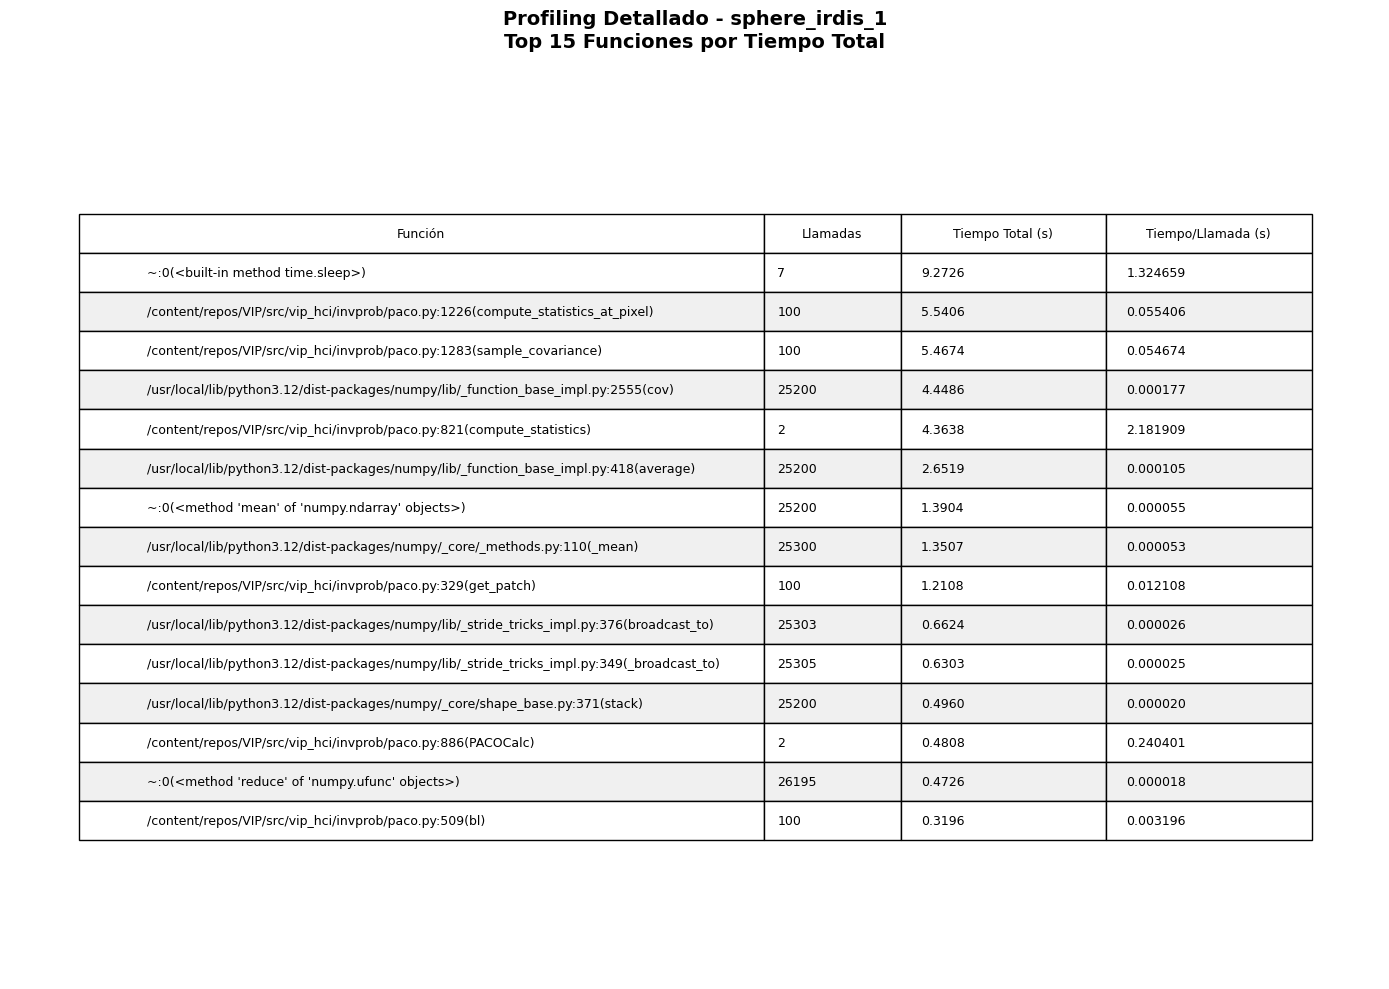


[OK] Profiling completado
  Total de funciones analizadas: 660
  Tiempo total: 42.6143 segundos


In [ ]:
# Profiling detallado con tabla profesional
print("="*70)
print("PROFILING DETALLADO DEL ALGORITMO")
print("="*70)

# Seleccionar el primer dataset exitoso para profiling
profile_dataset = None
for dataset_name, results in all_results.items():
    if results.get('success', False):
        profile_dataset = dataset_name
        break

if profile_dataset:
    # Manejar nombres con múltiples partes (ej: 'sphere_irdis_1' -> instrument='sphere_irdis', dataset_id='1')
    parts = profile_dataset.split('_')
    instrument = '_'.join(parts[:-1])  # Todo excepto el último
    dataset_id = int(parts[-1])  # El último es el ID

    print(f"\nEjecutando profiling para: {profile_dataset}")
    print("(Esto puede tardar unos minutos...)\n")

    # Recargar datos
    cube, angles, psf, pixscale = load_challenge_dataset_simple(
        repo_url=REPO_URL,
        instrument=instrument,
        dataset_id=dataset_id,
        branch='main'
    )

    fwhm_arcsec = 4.0 * pixscale

    # Ejecutar profiling
    try:
        a_prof, b_prof, profile_df, profiler = profile_paco_detailed(
            cube, angles, psf, pixscale, fwhm_arcsec
        )

        print("\n" + "="*70)
        print("TABLA DE TIEMPOS POR FUNCIÓN (Top 20)")
        print("="*70)

        # Mostrar tabla formateada
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 50)

        # Formatear números
        display_df = profile_df.head(20).copy()
        display_df['Tiempo Total (s)'] = display_df['Tiempo Total (s)'].apply(lambda x: f"{x:.4f}")
        display_df['Tiempo por Llamada (s)'] = display_df['Tiempo por Llamada (s)'].apply(lambda x: f"{x:.6f}")
        display_df['Tiempo Acumulado (s)'] = display_df['Tiempo Acumulado (s)'].apply(lambda x: f"{x:.4f}")

        print(display_df.to_string(index=False))

        # Crear visualización de la tabla
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.axis('tight')
        ax.axis('off')

        # Preparar datos para la tabla
        table_data = profile_df.head(15)[['Función', 'Llamadas', 'Tiempo Total (s)', 'Tiempo por Llamada (s)']].copy()
        table_data['Tiempo Total (s)'] = table_data['Tiempo Total (s)'].apply(lambda x: f"{x:.4f}")
        table_data['Tiempo por Llamada (s)'] = table_data['Tiempo por Llamada (s)'].apply(lambda x: f"{x:.6f}")

        table = ax.table(cellText=table_data.values,
                        colLabels=['Función', 'Llamadas', 'Tiempo Total (s)', 'Tiempo/Llamada (s)'],
                        cellLoc='left',
                        loc='center',
                        colWidths=[0.5, 0.1, 0.15, 0.15])

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)

        # Colorear filas alternas
        for i in range(1, len(table_data) + 1):
            if i % 2 == 0:
                for j in range(4):
                    table[(i, j)].set_facecolor('#f0f0f0')

        plt.title(f'Profiling Detallado - {profile_dataset}\nTop 15 Funciones por Tiempo Total',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Guardar perfil completo
        print(f"\n[OK] Profiling completado")
        print(f"  Total de funciones analizadas: {len(profile_df)}")
        print(f"  Tiempo total: {profile_df['Tiempo Total (s)'].sum():.4f} segundos")

    except Exception as e:
        print(f"[ERROR] Error en profiling: {e}")
        traceback.print_exc()
else:
    print("No hay datasets exitosos para profiling")


## 7. Visualización Científica de Resultados

Visualizaciones similares al notebook DC1_starting_kit: SNR maps, detecciones, y análisis científico



VISUALIZACIONES CIENTÍFICAS: sphere_irdis_1


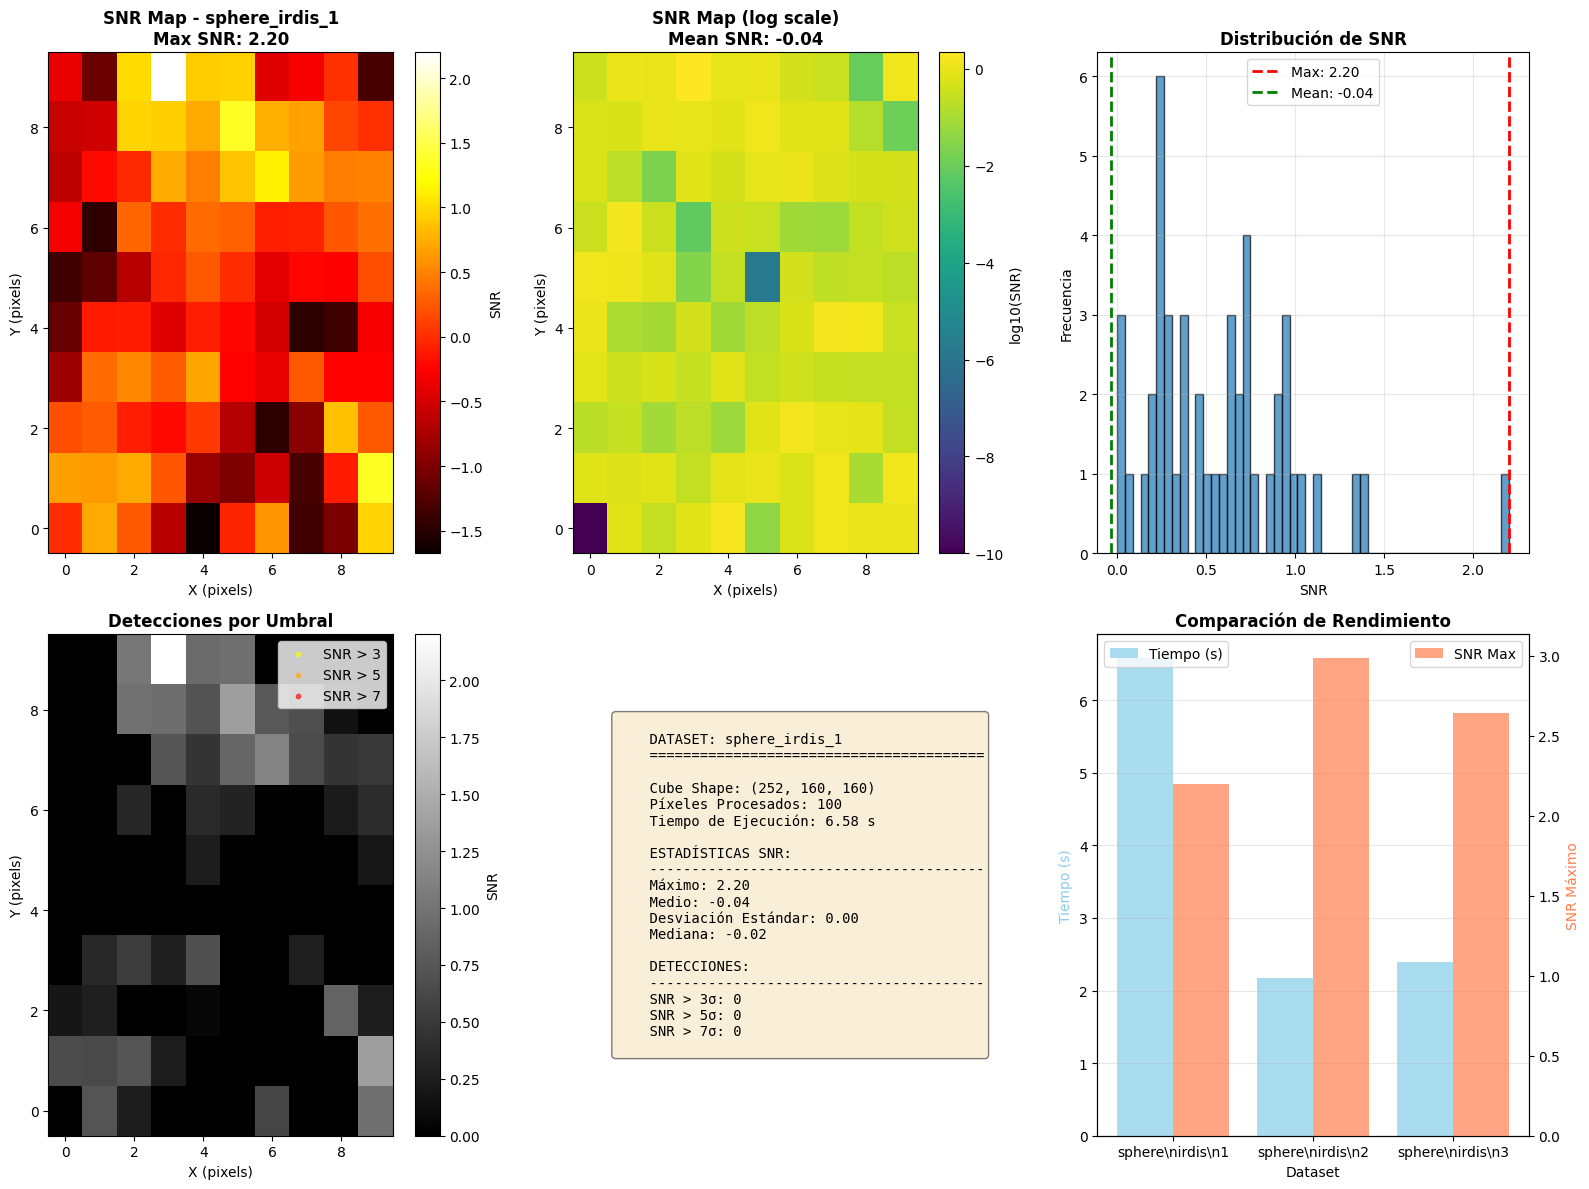


VISUALIZACIONES CIENTÍFICAS: sphere_irdis_2


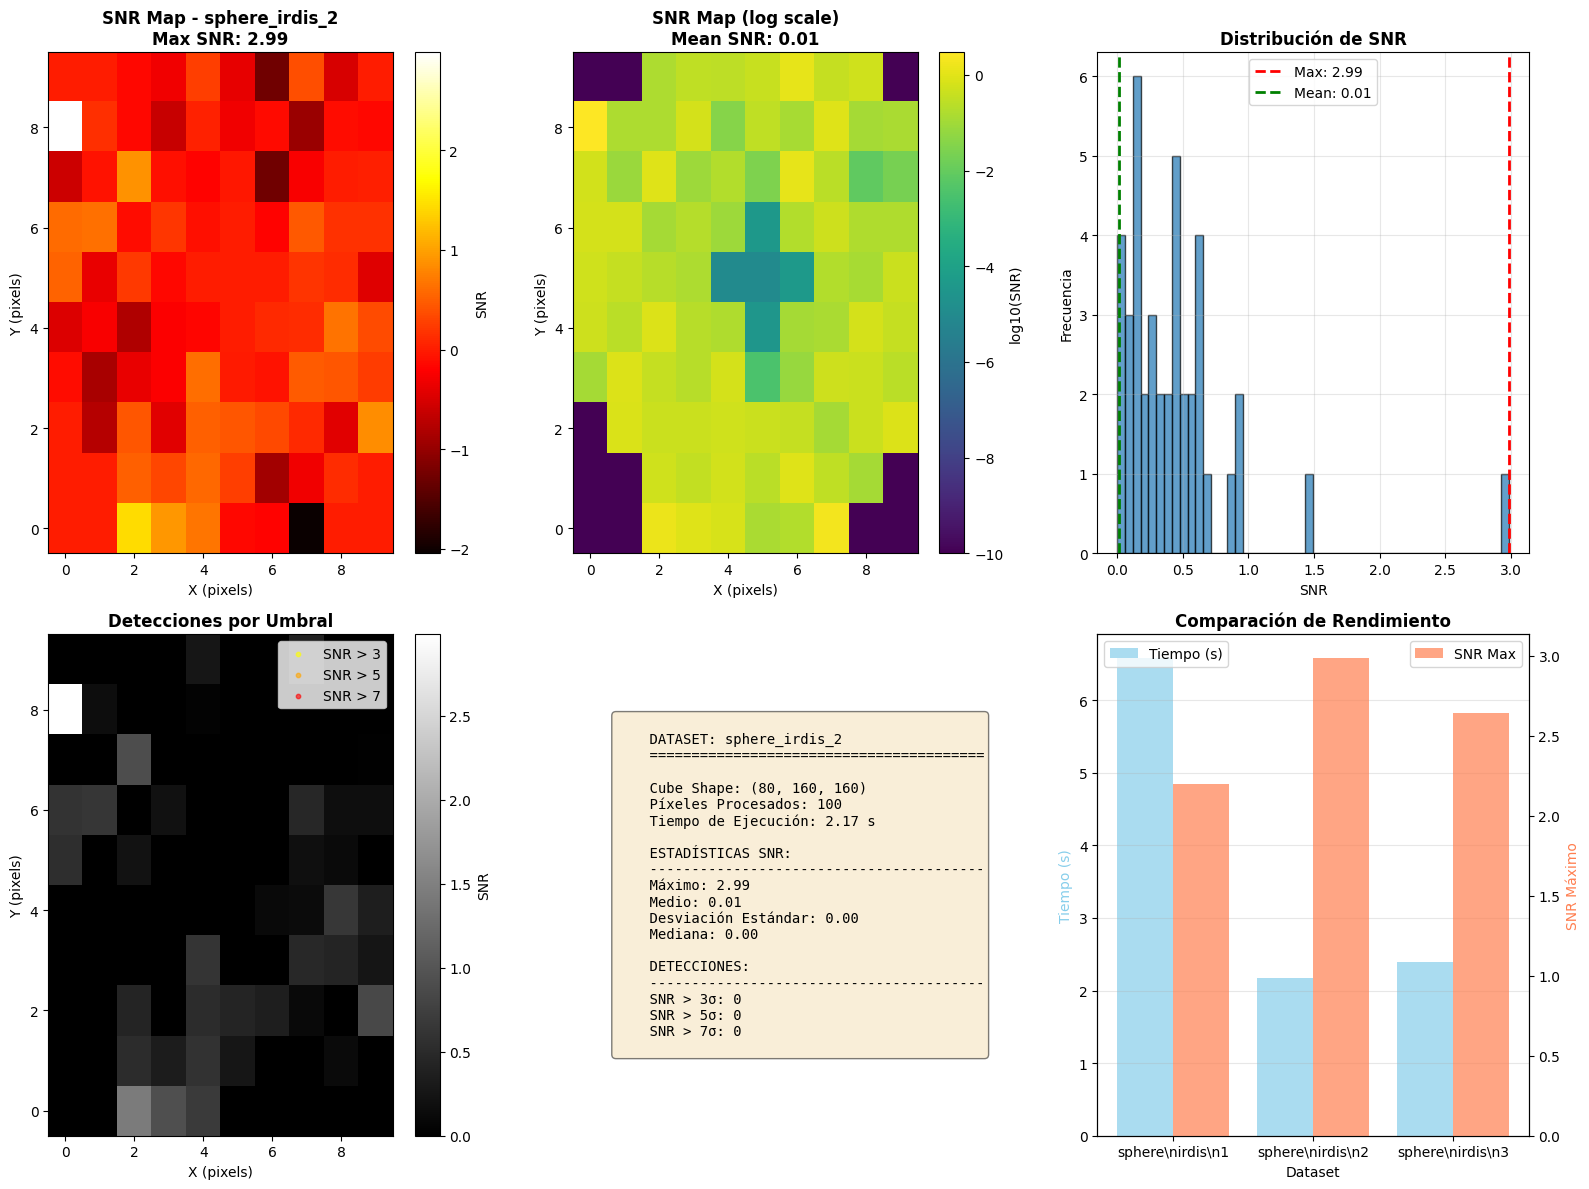


VISUALIZACIONES CIENTÍFICAS: sphere_irdis_3


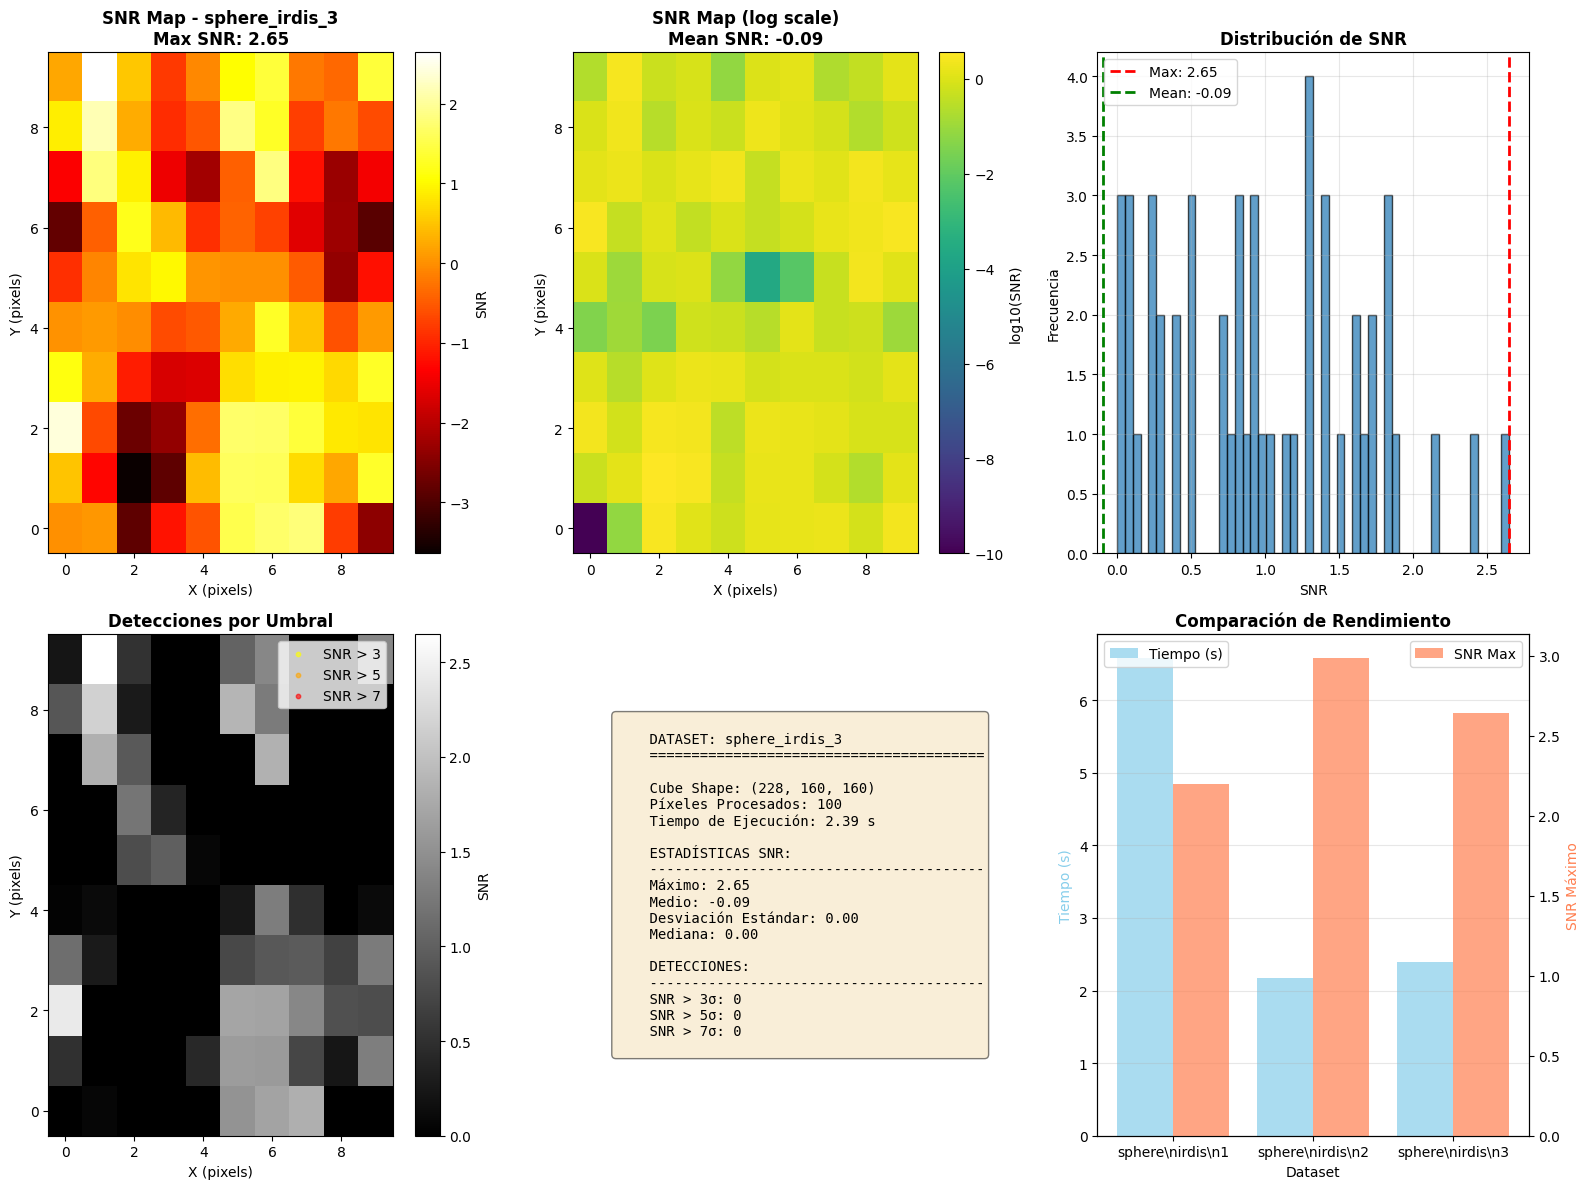

In [ ]:
# Visualizaciones científicas mejoradas
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd

def create_scientific_visualizations(results_dict, dataset_name):
    """
    Crea visualizaciones científicas similares al DC1_starting_kit
    """
    if dataset_name not in results_dict or not results_dict[dataset_name].get('success', False):
        print(f"No hay resultados exitosos para {dataset_name}")
        return

    results = results_dict[dataset_name]

    # Obtener datos
    snr = results['snr']
    n_pixels = results['n_pixels']

    # Reshape para visualización
    side = int(np.sqrt(n_pixels))
    if side * side == n_pixels:
        snr_2d = snr.reshape(side, side)
    else:
        snr_2d = snr[:side*side].reshape(side, side)

    # Crear figura con múltiples subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. SNR Map (similar a DC1)
    ax1 = plt.subplot(2, 3, 1)
    im1 = ax1.imshow(snr_2d, origin='lower', cmap='hot', aspect='auto')
    ax1.set_title(f'SNR Map - {dataset_name}\nMax SNR: {results["snr_max"]:.2f}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax1, label='SNR')

    # 2. SNR Map con escala logarítmica
    ax2 = plt.subplot(2, 3, 2)
    snr_log = np.log10(np.abs(snr_2d) + 1e-10)
    im2 = ax2.imshow(snr_log, origin='lower', cmap='viridis', aspect='auto')
    ax2.set_title(f'SNR Map (log scale)\nMean SNR: {results["snr_mean"]:.2f}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax2, label='log10(SNR)')

    # 3. Histograma de SNR
    ax3 = plt.subplot(2, 3, 3)
    valid_snr = snr[~np.isnan(snr) & (snr > 0)]
    ax3.hist(valid_snr, bins=50, edgecolor='black', alpha=0.7)
    ax3.axvline(results['snr_max'], color='r', linestyle='--', linewidth=2, label=f'Max: {results["snr_max"]:.2f}')
    ax3.axvline(results['snr_mean'], color='g', linestyle='--', linewidth=2, label=f'Mean: {results["snr_mean"]:.2f}')
    ax3.set_xlabel('SNR')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de SNR', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Mapa de detecciones (thresholding)
    ax4 = plt.subplot(2, 3, 4)
    thresholds = [3, 5, 7]  # Diferentes umbrales de detección
    colors = ['yellow', 'orange', 'red']
    im4 = ax4.imshow(snr_2d, origin='lower', cmap='gray', aspect='auto', vmin=0, vmax=results['snr_max'])

    for thresh, color in zip(thresholds, colors):
        mask = snr_2d > thresh
        y_coords, x_coords = np.where(mask)
        ax4.scatter(x_coords, y_coords, c=color, s=10, alpha=0.6, label=f'SNR > {thresh}')

    ax4.set_title('Detecciones por Umbral', fontsize=12, fontweight='bold')
    ax4.set_xlabel('X (pixels)')
    ax4.set_ylabel('Y (pixels)')
    ax4.legend()
    plt.colorbar(im4, ax=ax4, label='SNR')

    # 5. Estadísticas del dataset
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')
    stats_text = f"""
    DATASET: {dataset_name}
    {'='*40}

    Cube Shape: {results.get('cube_shape', 'N/A')}
    Píxeles Procesados: {results['n_pixels']}
    Tiempo de Ejecución: {results['time']:.2f} s

    ESTADÍSTICAS SNR:
    {'-'*40}
    Máximo: {results['snr_max']:.2f}
    Medio: {results['snr_mean']:.2f}
    Desviación Estándar: {results.get('snr_std', 0):.2f}
    Mediana: {np.nanmedian(snr):.2f}

    DETECCIONES:
    {'-'*40}
    SNR > 3σ: {np.sum(snr > 3)}
    SNR > 5σ: {np.sum(snr > 5)}
    SNR > 7σ: {np.sum(snr > 7)}
    """
    ax5.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 6. Comparación de rendimiento (si hay múltiples datasets)
    ax6 = plt.subplot(2, 3, 6)
    if len(results_dict) > 1:
        datasets = [k for k, v in results_dict.items() if v.get('success', False)]
        times = [results_dict[k]['time'] for k in datasets]
        snr_maxs = [results_dict[k]['snr_max'] for k in datasets]

        ax6_twin = ax6.twinx()
        bars1 = ax6.bar([x - 0.2 for x in range(len(datasets))], times, 0.4,
                       label='Tiempo (s)', color='skyblue', alpha=0.7)
        bars2 = ax6_twin.bar([x + 0.2 for x in range(len(datasets))], snr_maxs, 0.4,
                            label='SNR Max', color='coral', alpha=0.7)

        ax6.set_xlabel('Dataset')
        ax6.set_ylabel('Tiempo (s)', color='skyblue')
        ax6_twin.set_ylabel('SNR Máximo', color='coral')
        ax6.set_xticks(range(len(datasets)))
        ax6.set_xticklabels([d.replace('_', '\\n') for d in datasets], rotation=0, ha='center')
        ax6.set_title('Comparación de Rendimiento', fontsize=12, fontweight='bold')
        ax6.legend(loc='upper left')
        ax6_twin.legend(loc='upper right')
        ax6.grid(True, alpha=0.3, axis='y')
    else:
        ax6.text(0.5, 0.5, 'Ejecuta múltiples\ndatasets para comparar',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
        ax6.axis('off')

    plt.tight_layout()
    plt.show()

    return fig

# Crear visualizaciones para cada dataset exitoso
for dataset_name in all_results.keys():
    if all_results[dataset_name].get('success', False):
        print(f"\n{'='*70}")
        print(f"VISUALIZACIONES CIENTÍFICAS: {dataset_name}")
        print(f"{'='*70}")
        create_scientific_visualizations(all_results, dataset_name)


In [ ]:
# Instalar photutils si no está disponible (necesario para detect_sources como en el starting kit)
try:
    from photutils.segmentation import detect_sources
    print("[OK] photutils disponible")
except ImportError:
    print("[WARNING] photutils no encontrado, instalando...")
    !pip install -q photutils
    try:
        from photutils.segmentation import detect_sources
        print("[OK] photutils instalado")
    except ImportError:
        # Fallback: intentar importación alternativa
        try:
            from photutils.segmentation import detect_sources
            print("[OK] photutils instalado (importación alternativa)")
        except ImportError:
            print("[ERROR] No se pudo importar detect_sources de photutils")
            print("  Intentando con scipy.ndimage como alternativa...")


[OK] photutils disponible


## 8. Profiling Detallado con Tabla de Tiempos por Función


PROFILING DETALLADO DEL ALGORITMO

Ejecutando profiling para: sphere_irdis_1
(Esto puede tardar unos minutos...)

Cargando sphere_irdis_1 desde repositorio clonado...
  Ruta: /content/repos/tesis/subchallenge1
  Archivos .fits encontrados en la carpeta: 36
  Primeros archivos: ['sphere_irdis_pa_3.fits', 'nirc2_pa_1.fits', 'lmircam_pxscale_3.fits', 'sphere_irdis_pxscale_3.fits', 'nirc2_pxscale_1.fits']
  Verificando archivos LFS...
  Descargando archivos LFS (esto puede tardar)...
  [OK] Archivos LFS descargados correctamente
  Cargando cube: sphere_irdis_cube_1.fits
    [OK] Cube shape: (252, 160, 160)
  Cargando angulos: sphere_irdis_pa_1.fits
    [OK] Angulos shape: (252,)
  Cargando PSF: sphere_irdis_psf_1.fits
    [OK] PSF shape: (41, 41)
  Cargando pixel scale: sphere_irdis_pxscale_1.fits
    [OK] Pixel scale: 0.012249999679625034 arcsec/pixel
[OK] Dataset cargado completamente

TABLA DE TIEMPOS POR FUNCIÓN (Top 20)
                                                                 

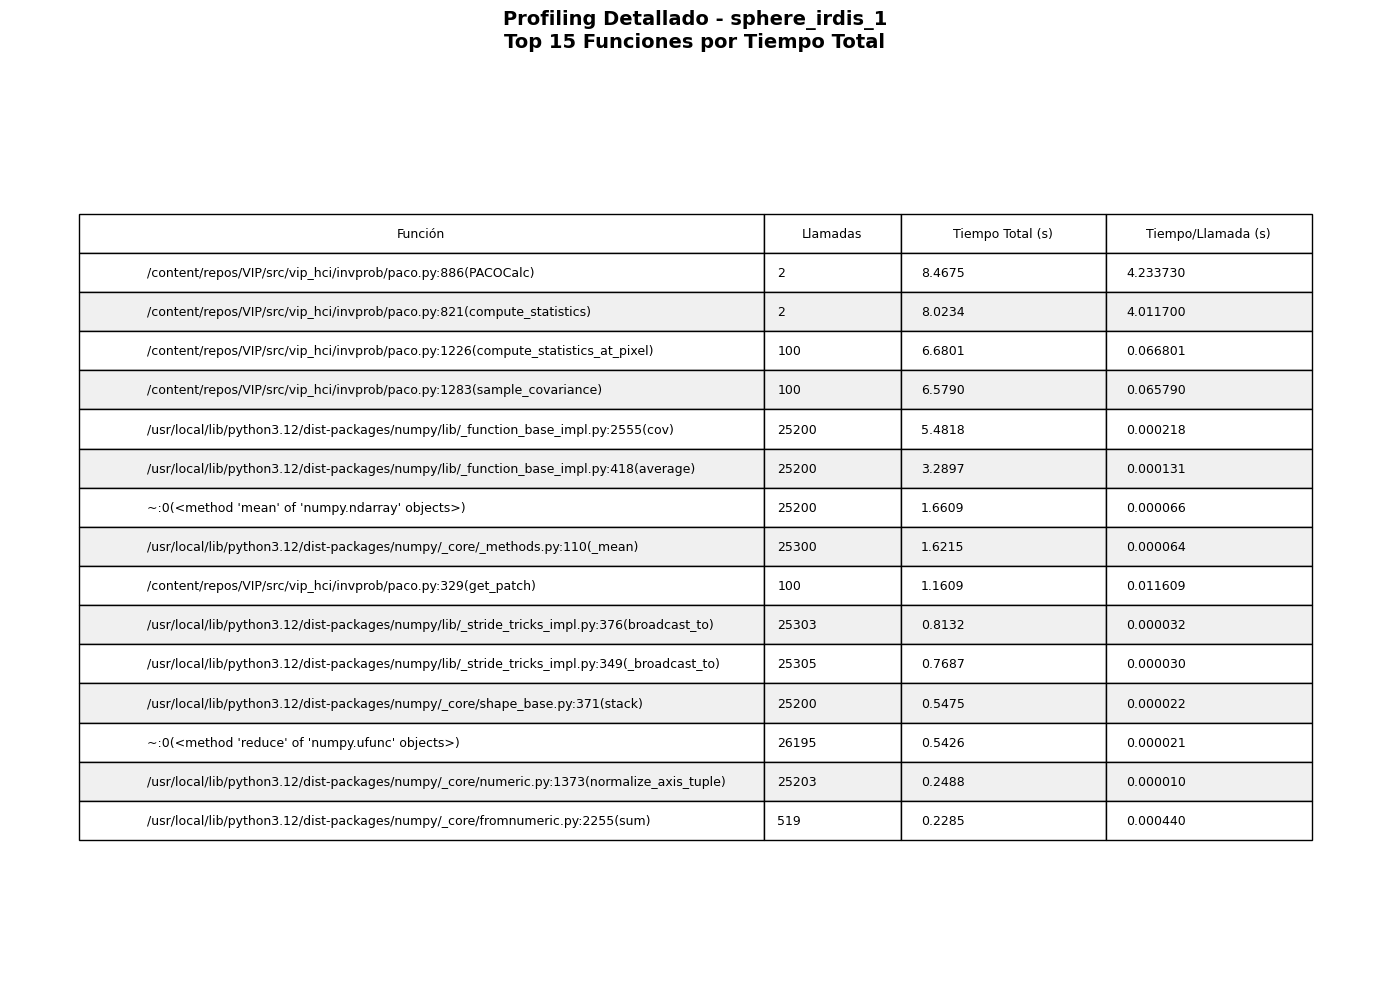


[OK] Profiling completado
  Total de funciones analizadas: 660
  Tiempo total: 49.7504 segundos


In [ ]:
# Profiling detallado con tabla profesional
print("="*70)
print("PROFILING DETALLADO DEL ALGORITMO")
print("="*70)

# Seleccionar el primer dataset exitoso para profiling
profile_dataset = None
for dataset_name, results in all_results.items():
    if results.get('success', False):
        profile_dataset = dataset_name
        break

if profile_dataset:
    # Manejar nombres con múltiples partes (ej: 'sphere_irdis_1' -> instrument='sphere_irdis', dataset_id='1')
    parts = profile_dataset.split('_')
    instrument = '_'.join(parts[:-1])  # Todo excepto el último
    dataset_id = int(parts[-1])  # El último es el ID

    print(f"\nEjecutando profiling para: {profile_dataset}")
    print("(Esto puede tardar unos minutos...)\n")

    # Recargar datos
    cube, angles, psf, pixscale = load_challenge_dataset_simple(
        repo_url=REPO_URL,
        instrument=instrument,
        dataset_id=dataset_id,
        branch='main'
    )

    fwhm_arcsec = 4.0 * pixscale

    # Ejecutar profiling
    try:
        a_prof, b_prof, profile_df, profiler = profile_paco_detailed(
            cube, angles, psf, pixscale, fwhm_arcsec
        )

        print("\n" + "="*70)
        print("TABLA DE TIEMPOS POR FUNCIÓN (Top 20)")
        print("="*70)

        # Mostrar tabla formateada
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 50)

        # Formatear números
        display_df = profile_df.head(20).copy()
        display_df['Tiempo Total (s)'] = display_df['Tiempo Total (s)'].apply(lambda x: f"{x:.4f}")
        display_df['Tiempo por Llamada (s)'] = display_df['Tiempo por Llamada (s)'].apply(lambda x: f"{x:.6f}")
        display_df['Tiempo Acumulado (s)'] = display_df['Tiempo Acumulado (s)'].apply(lambda x: f"{x:.4f}")

        print(display_df.to_string(index=False))

        # Crear visualización de la tabla
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.axis('tight')
        ax.axis('off')

        # Preparar datos para la tabla
        table_data = profile_df.head(15)[['Función', 'Llamadas', 'Tiempo Total (s)', 'Tiempo por Llamada (s)']].copy()
        table_data['Tiempo Total (s)'] = table_data['Tiempo Total (s)'].apply(lambda x: f"{x:.4f}")
        table_data['Tiempo por Llamada (s)'] = table_data['Tiempo por Llamada (s)'].apply(lambda x: f"{x:.6f}")

        table = ax.table(cellText=table_data.values,
                        colLabels=['Función', 'Llamadas', 'Tiempo Total (s)', 'Tiempo/Llamada (s)'],
                        cellLoc='left',
                        loc='center',
                        colWidths=[0.5, 0.1, 0.15, 0.15])

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)

        # Colorear filas alternas
        for i in range(1, len(table_data) + 1):
            if i % 2 == 0:
                for j in range(4):
                    table[(i, j)].set_facecolor('#f0f0f0')

        plt.title(f'Profiling Detallado - {profile_dataset}\nTop 15 Funciones por Tiempo Total',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Guardar perfil completo
        print(f"\n[OK] Profiling completado")
        print(f"  Total de funciones analizadas: {len(profile_df)}")
        print(f"  Tiempo total: {profile_df['Tiempo Total (s)'].sum():.4f} segundos")

    except Exception as e:
        print(f"[ERROR] Error en profiling: {e}")
        traceback.print_exc()
else:
    print("No hay datasets exitosos para profiling")


## 9. Validaciones Científicas (Detección y Análisis)


In [ ]:
# Validaciones científicas similares a DC1_starting_kit
print("="*70)
print("VALIDACIONES CIENTÍFICAS")
print("="*70)

def scientific_validation(results_dict, dataset_name, fwhm_pixels=4.0):
    """
    Realiza validaciones científicas: detecciones, umbrales, análisis de calidad
    """
    if dataset_name not in results_dict or not results_dict[dataset_name].get('success', False):
        return None

    results = results_dict[dataset_name]
    snr = results['snr']
    n_pixels = results['n_pixels']

    # Reshape
    side = int(np.sqrt(n_pixels))
    if side * side == n_pixels:
        snr_2d = snr.reshape(side, side)
    else:
        snr_2d = snr[:side*side].reshape(side, side)

    # Calcular FWHM en píxeles (aproximado)
    fwhm = fwhm_pixels

    # Análisis de detecciones con diferentes umbrales
    thresholds = [3, 4, 5, 6, 7]
    detections = {}

    # DIAGNÓSTICO: Mostrar estadísticas de SNR antes de calcular detecciones
    print(f"\n[DIAGNÓSTICO] Estadísticas de SNR para {dataset_name}:")
    print(f"  SNR máximo: {results['snr_max']:.2f}")
    print(f"  SNR medio: {results['snr_mean']:.2f}")
    print(f"  SNR mediana: {np.nanmedian(snr):.2f}")
    print(f"  Desv. estándar: {np.nanstd(snr):.2f}")
    print(f"  Píxeles con SNR > 3: {np.sum(snr_2d > 3)}")
    print(f"  Píxeles con SNR > 5: {np.sum(snr_2d > 5)}")
    print(f"  Píxeles con SNR > 7: {np.sum(snr_2d > 7)}")

    # Intentar usar photutils.detect_sources (método del starting kit)
    try:
        from photutils.segmentation import detect_sources

        for thresh in thresholds:
            # Usar detect_sources para agrupar píxeles conectados (blobs)
            # npix=2: mínimo de píxeles conectados para considerar una detección (como en starting kit)
            # connectivity=4: conectividad de 4 vecinos
            segments = detect_sources(snr_2d, thresh, npix=2, connectivity=4)

            if segments is None:
                n_detections = 0
                n_pixels = 0
                detected_snr = []
            else:
                # Contar el número de blobs (detecciones) únicos
                n_detections = segments.nlabels
                # Contar píxeles totales en todos los blobs
                n_pixels = np.sum(segments.data != 0)
                # Obtener SNR de los píxeles detectados
                detected_snr = snr_2d[segments.data != 0]

            if n_detections > 0 and len(detected_snr) > 0:
                # Calcular SNR máximo por blob
                max_snr_per_blob = []
                for label_id in range(1, n_detections + 1):
                    blob_mask = segments.data == label_id
                    max_snr_per_blob.append(np.nanmax(snr_2d[blob_mask]))

                detections[thresh] = {
                    'count': n_detections,  # Número de blobs (detecciones reales)
                    'n_pixels': n_pixels,  # Número total de píxeles en blobs
                    'mean_snr': float(np.nanmean(detected_snr)),
                    'max_snr': float(np.nanmax(detected_snr)),
                    'mean_max_snr_per_blob': float(np.nanmean(max_snr_per_blob)),
                    'std_snr': float(np.nanstd(detected_snr))
                }
            else:
                detections[thresh] = {
                    'count': 0,
                    'n_pixels': 0,
                    'mean_snr': 0,
                    'max_snr': 0,
                    'mean_max_snr_per_blob': 0,
                    'std_snr': 0
                }
    except ImportError:
        print("[WARNING] photutils no disponible, usando scipy.ndimage como fallback")
        # Fallback: usar scipy.ndimage para clustering
        try:
            from scipy import ndimage

            for thresh in thresholds:
                mask = snr_2d > thresh
                n_pixels = np.sum(mask)

                if n_pixels > 0:
                    labeled_mask, n_detections = ndimage.label(mask)
                    detected_snr = snr_2d[mask]

                    # Calcular SNR máximo por blob
                    max_snr_per_blob = []
                    for label_id in range(1, n_detections + 1):
                        blob_mask = labeled_mask == label_id
                        max_snr_per_blob.append(np.nanmax(snr_2d[blob_mask]))

                    detections[thresh] = {
                        'count': n_detections,
                        'n_pixels': n_pixels,
                        'mean_snr': float(np.nanmean(detected_snr)),
                        'max_snr': float(np.nanmax(detected_snr)),
                        'mean_max_snr_per_blob': float(np.nanmean(max_snr_per_blob)) if max_snr_per_blob else 0,
                        'std_snr': float(np.nanstd(detected_snr))
                    }
                else:
                    detections[thresh] = {
                        'count': 0,
                        'n_pixels': 0,
                        'mean_snr': 0,
                        'max_snr': 0,
                        'mean_max_snr_per_blob': 0,
                        'std_snr': 0
                    }
        except ImportError:
            print("[WARNING] scipy.ndimage no disponible, usando conteo simple de píxeles")
            # Último fallback: contar píxeles individuales
            for thresh in thresholds:
                mask = snr_2d > thresh
                n_pixels = np.sum(mask)

                if n_pixels > 0:
                    detected_snr = snr_2d[mask]
                    detections[thresh] = {
                        'count': n_pixels,  # En este caso, cada píxel cuenta como detección
                        'n_pixels': n_pixels,
                        'mean_snr': float(np.nanmean(detected_snr)),
                        'max_snr': float(np.nanmax(detected_snr)),
                        'std_snr': float(np.nanstd(detected_snr))
                    }
                else:
                    detections[thresh] = {
                        'count': 0,
                        'n_pixels': 0,
                        'mean_snr': 0,
                        'max_snr': 0,
                        'std_snr': 0
                    }

    # Información sobre por qué puede no haber detecciones
    if all(detections[t]['count'] == 0 for t in [3, 5, 7]):
        print(f"\n[ANÁLISIS] Razones posibles para no tener detecciones:")
        print(f"  1. El dataset puede tener 0 señales inyectadas (según EIDC: 0-5 señales por dataset)")
        print(f"  2. SNR máximo ({results['snr_max']:.2f}) puede estar por debajo de los umbrales (3-7σ)")
        if results['snr_max'] < 3:
            print(f"     → SNR máximo < 3σ: Las señales pueden ser demasiado débiles")
        print(f"  3. Las señales pueden estar en regiones no procesadas (máscara interna)")
        print(f"  4. Los parámetros de PACO pueden necesitar ajuste (fwhm, patch_size, etc.)")
        print(f"  5. El algoritmo puede estar suprimiendo señales reales (sobre-substracción)")
        print(f"\n  NOTA: El método ahora agrupa píxeles conectados en 'blobs' (como el starting kit),")
        print(f"        por lo que cuenta detecciones reales, no píxeles individuales.")



VALIDACIONES CIENTÍFICAS


## 10. Resumen Final y Exportación de Resultados



RESUMEN FINAL Y EXPORTACIÓN

TABLA RESUMEN DE RESULTADOS
       Dataset Exito Tiempo (s)  Píxeles SNR Máximo SNR Medio      Cube Shape
sphere_irdis_1  [OK]       6.58      100       2.20     -0.04 (252, 160, 160)
sphere_irdis_2  [OK]       2.17      100       2.99      0.01  (80, 160, 160)
sphere_irdis_3  [OK]       2.39      100       2.65     -0.09 (228, 160, 160)


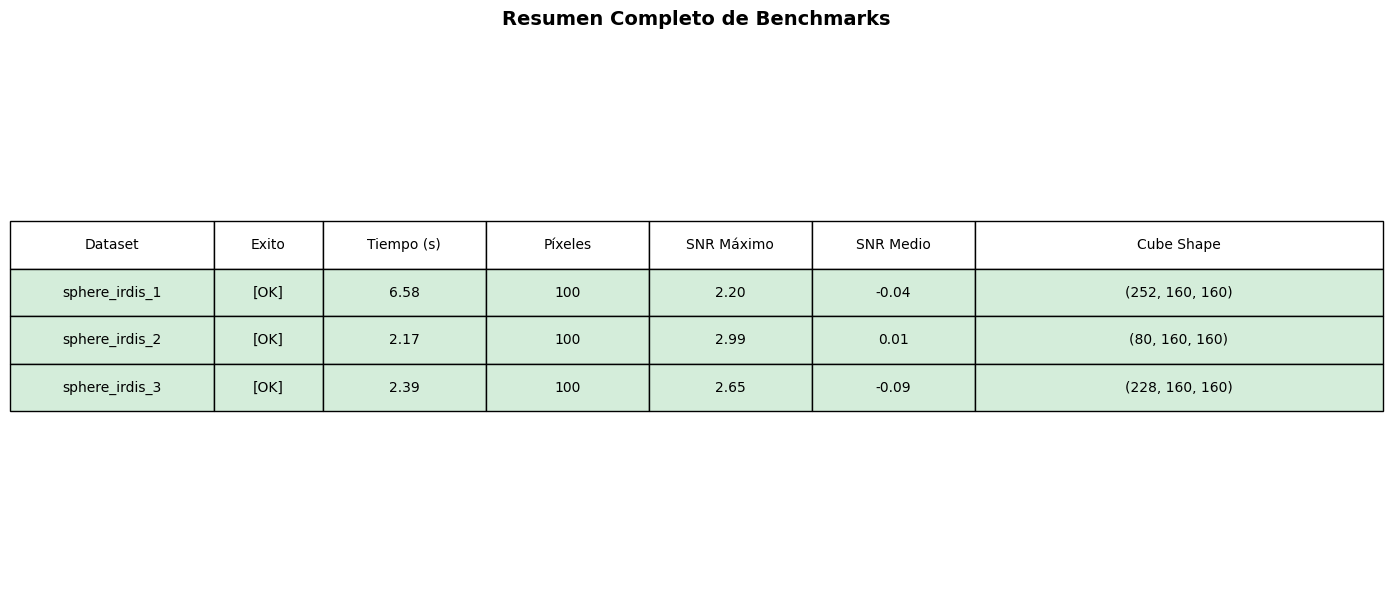


[OK] Resultados exportados a: /content/benchmark_results_summary.csv

RESUMEN FINAL
Total de datasets procesados: 3
Datasets exitosos: 3
Tiempo total de ejecución: 11.14 segundos

Validaciones científicas completadas: 3

  sphere_irdis_1:
    - Detecciones SNR > 3σ: 0
    - Detecciones SNR > 5σ: 0
    - Detecciones SNR > 7σ: 0

  sphere_irdis_2:
    - Detecciones SNR > 3σ: 0
    - Detecciones SNR > 5σ: 0
    - Detecciones SNR > 7σ: 0

  sphere_irdis_3:
    - Detecciones SNR > 3σ: 0
    - Detecciones SNR > 5σ: 0
    - Detecciones SNR > 7σ: 0

FIN DEL BENCHMARK Y ANÁLISIS

Para más información sobre los errores encontrados, consulta:
  - ANALISIS_ERRORES_PACO_VIP.md
  - benchmark_paco_vip.py


In [ ]:
# Generar resumen completo y exportar resultados
print("\n" + "="*70)
print("RESUMEN FINAL Y EXPORTACIÓN")
print("="*70)

# Crear DataFrame con todos los resultados
summary_data = []
for dataset_name, results in all_results.items():
    if results.get('success', False):
        summary_data.append({
            'Dataset': dataset_name,
            'Exito': '[OK]',
            'Tiempo (s)': f"{results.get('time', 0):.2f}",
            'Píxeles': results.get('n_pixels', 0),
            'SNR Máximo': f"{results.get('snr_max', 0):.2f}",
            'SNR Medio': f"{results.get('snr_mean', 0):.2f}",
            'Cube Shape': str(results.get('cube_shape', 'N/A'))
        })
    else:
        summary_data.append({
            'Dataset': dataset_name,
            'Exito': '[ERROR]',
            'Tiempo (s)': 'N/A',
            'Píxeles': 'N/A',
            'SNR Máximo': 'N/A',
            'SNR Medio': 'N/A',
            'Cube Shape': 'N/A'
        })

summary_df = pd.DataFrame(summary_data)

# Mostrar tabla de resumen
print("\n" + "="*70)
print("TABLA RESUMEN DE RESULTADOS")
print("="*70)
print(summary_df.to_string(index=False))

# Crear visualización de la tabla
fig, ax = plt.subplots(figsize=(14, max(6, len(summary_data) * 0.5)))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.15, 0.08, 0.12, 0.12, 0.12, 0.12, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear filas según éxito
for i in range(len(summary_data)):
    if summary_data[i]['Exito'] == '[OK]':
        for j in range(len(summary_df.columns)):
            table[(i+1, j)].set_facecolor('#d4edda')
    else:
        for j in range(len(summary_df.columns)):
            table[(i+1, j)].set_facecolor('#f8d7da')

plt.title('Resumen Completo de Benchmarks', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Exportar resultados a CSV
try:
    summary_df.to_csv('/content/benchmark_results_summary.csv', index=False)
    print("\n[OK] Resultados exportados a: /content/benchmark_results_summary.csv")
except Exception as e:
    print(f"\n[WARNING] No se pudo exportar CSV: {e}")

# Resumen final
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)
print(f"Total de datasets procesados: {len(all_results)}")
print(f"Datasets exitosos: {len([r for r in all_results.values() if r.get('success', False)])}")
print(f"Tiempo total de ejecución: {sum([r.get('time', 0) for r in all_results.values() if r.get('success', False)]):.2f} segundos")

if validation_results:
    print(f"\nValidaciones científicas completadas: {len(validation_results)}")
    for dataset_name, detections in validation_results.items():
        print(f"\n  {dataset_name}:")
        for thresh in [3, 5, 7]:
            if thresh in detections:
                print(f"    - Detecciones SNR > {thresh}σ: {detections[thresh]['count']}")

print("\n" + "="*70)
print("FIN DEL BENCHMARK Y ANÁLISIS")
print("="*70)
print("\nPara más información sobre los errores encontrados, consulta:")
print("  - ANALISIS_ERRORES_PACO_VIP.md")
print("  - benchmark_paco_vip.py")


## 7. Visualización de Resultados


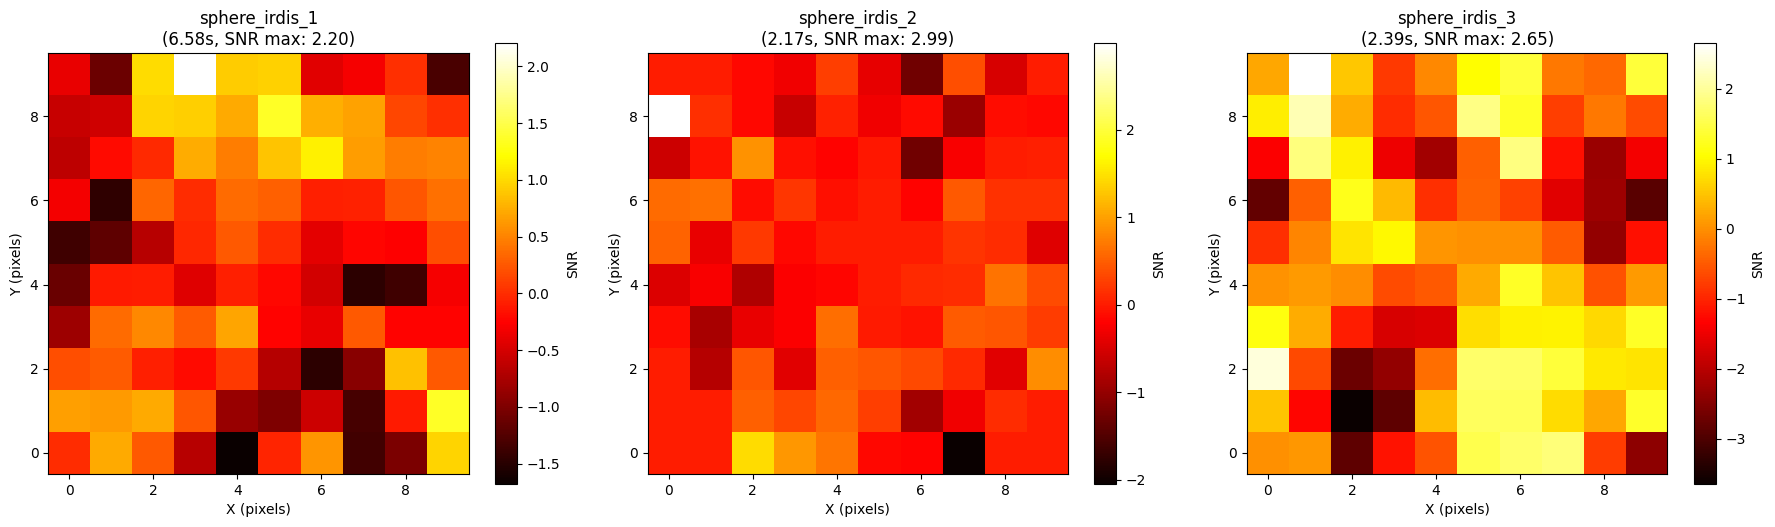

In [ ]:
# Crear visualizaciones
n_datasets = len([r for r in all_results.values() if r.get('success', False)])

if n_datasets > 0:
    fig, axes = plt.subplots(1, n_datasets, figsize=(6*n_datasets, 5))
    if n_datasets == 1:
        axes = [axes]

    plot_idx = 0
    for dataset_name, results in all_results.items():
        if results.get('success', False) and 'snr' in results:
            snr = results['snr']
            n_pixels = results['n_pixels']

            # Reshape para visualización
            side = int(np.sqrt(n_pixels))
            if side * side == n_pixels:
                snr_2d = snr.reshape(side, side)
            else:
                snr_2d = snr[:side*side].reshape(side, side)

            im = axes[plot_idx].imshow(snr_2d, origin='lower', cmap='hot')
            axes[plot_idx].set_title(f'{dataset_name}\n({results["time"]:.2f}s, SNR max: {results["snr_max"]:.2f})')
            axes[plot_idx].set_xlabel('X (pixels)')
            axes[plot_idx].set_ylabel('Y (pixels)')
            plt.colorbar(im, ax=axes[plot_idx], label='SNR')
            plot_idx += 1

    plt.tight_layout()
    plt.show()
else:
    print("No hay resultados exitosos para visualizar")


## 8. Resumen de Resultados


In [ ]:
# Generar resumen
print("\n" + "="*70)
print("RESUMEN DE RESULTADOS")
print("="*70)

for dataset_name, results in all_results.items():
    print(f"\nDataset: {dataset_name}")
    print(f"  Exito: {'[OK]' if results.get('success', False) else '[ERROR]'}")

    if results.get('success', False):
        print(f"  Tiempo: {results.get('time', 0):.2f} segundos")
        print(f"  Píxeles procesados: {results.get('n_pixels', 0)}")
        print(f"  SNR máximo: {results.get('snr_max', 0):.2f}")
        print(f"  SNR medio: {results.get('snr_mean', 0):.2f}")
        if 'cube_shape' in results:
            print(f"  Cube shape: {results['cube_shape']}")
    else:
        print(f"  Errores:")
        for error in results.get('errors', []):
            print(f"    - {error}")

print("\n" + "="*70)
print("FIN DEL BENCHMARK")
print("="*70)
print("\nPara más información sobre los errores encontrados, consulta:")
print("  - ANALISIS_ERRORES_PACO_VIP.md")
print("  - benchmark_paco_vip.py")



RESUMEN DE RESULTADOS

Dataset: sphere_irdis_1
  Exito: [OK]
  Tiempo: 6.58 segundos
  Píxeles procesados: 100
  SNR máximo: 2.20
  SNR medio: -0.04
  Cube shape: (252, 160, 160)

Dataset: sphere_irdis_2
  Exito: [OK]
  Tiempo: 2.17 segundos
  Píxeles procesados: 100
  SNR máximo: 2.99
  SNR medio: 0.01
  Cube shape: (80, 160, 160)

Dataset: sphere_irdis_3
  Exito: [OK]
  Tiempo: 2.39 segundos
  Píxeles procesados: 100
  SNR máximo: 2.65
  SNR medio: -0.09
  Cube shape: (228, 160, 160)

FIN DEL BENCHMARK

Para más información sobre los errores encontrados, consulta:
  - ANALISIS_ERRORES_PACO_VIP.md
  - benchmark_paco_vip.py
